In [1]:
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
mal_path = "malicious_pure/"
pure_path = "powershell_benign_dataset/"

In [3]:
# make dataset csv and add labels
def load_scripts_into_dataframe(folder_path, label):
    script_list = []
    
    # Traverse through the folder and read each PowerShell script
    for file_path in glob.glob(os.path.join(folder_path, '*.ps1')):
        with open(file_path, 'r') as file:
            script_content = file.read()
            script_list.append((script_content, label))
    
    # Create a DataFrame with 'script' and 'label' columns
    df = pd.DataFrame(script_list, columns=['script', 'label'])
    
    return df

In [4]:
# Load scripts into DataFrames
# malicious - 0
# benign - 1
malicious_df = load_scripts_into_dataframe(mal_path, label=0)
benign_df = load_scripts_into_dataframe(pure_path, label=1)

In [5]:
# Combine the DataFrames
mal_df = pd.concat([malicious_df, benign_df], ignore_index=True)
# mal_df.to_csv("mal.csv", index=False)

In [6]:
# check if the data is balanced
label_counts = mal_df['label'].value_counts()
print(label_counts)

label
1    4316
0    4202
Name: count, dtype: int64


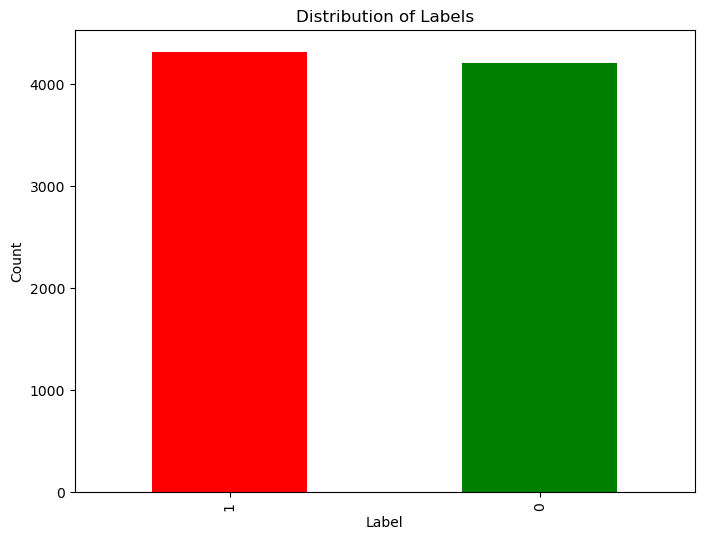

In [7]:
# Plotting the bar chart
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
# If you want to check for NaN values in the entire DataFrame
nan_check = mal_df.isna().any().any()
# If you want to check for NaN values in a specific column, for example, 'script'
nan_check_in_script = mal_df['script'].isna().any()
# Print the result
print(f"Are there NaN values in the DataFrame? {nan_check}")
print(f"Are there NaN values in the 'script' column? {nan_check_in_script}")

Are there NaN values in the DataFrame? False
Are there NaN values in the 'script' column? False


## Extracting features

In [9]:
def clean_script(script):
    # Remove comments from the script
    script = re.sub(r'#.*$', ' ', script, flags=re.MULTILINE)
    
    # Remove special characters and reduce consecutive spaces
    cleaned_script = re.sub(r'\s+', ' ', script)
    
    # Remove tabs and newlines
    cleaned_script = cleaned_script.replace('\t', ' ').replace('\n', ' ')
    
    # Remove punctuation
    cleaned_script = re.sub(r'[^\w\s]', ' ', cleaned_script).lower()
    
    return cleaned_script

In [10]:
mal_df.loc[:, 'cleaned_script'] = mal_df['script'].apply(clean_script)

In [11]:
mal_df

,script,label,cleaned_script
0,"\n$c = '[DllImport(""kernel32.dll"")]public stat...",0,c dllimport kernel32 dll public stati...
1,\n(New-Object System.Net.WebClient).DownloadFi...,0,new object system net webclient downloadfil...
2,"\n$x=$Env:username;$u=""http://54.213.195.138/s...",0,x env username u http 54 213 195 138 s2...
3,\n(New-Object System.Net.WebClient).DownloadFi...,0,new object system net webclient downloadfil...
4,\n(New-Object System.Net.WebClient).DownloadFi...,0,new object system net webclient downloadfil...
...,...,...,...
8513,\n\n\nfunction Set-RsEmailSettings\n{\n \n ...,1,function set rsemailsettings cmdletbinding...
8514,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nfunction Test-E2...,1,function test e2eschedules resourcegroupna...
8515,\n\n\n\nfunction Get-AuthToken {\n\n\n\n[cmdle...,1,function get authtoken cmdletbinding pa...
8516,﻿function Get-MSHotFixes\n{\n\n\n$hotfixes = G...,1,function get mshotfixes hotfixes get wmi...


## TF-IDF without extra features

In [12]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Extract features and labels
X = mal_df['cleaned_script']
y = mal_df['label']

# Create TF-IDF vectorizer
ngram_range = (1, 2)  
max_features = 1000 

# Create TF-IDF vectorizer with specified parameters
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
# Fit and transform the data
X_tfidf = vectorizer.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)


In [13]:
from sklearn.linear_model import LogisticRegression

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9841549295774648
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       837
           1       0.97      1.00      0.98       867

    accuracy                           0.98      1704
   macro avg       0.98      0.98      0.98      1704
weighted avg       0.98      0.98      0.98      1704



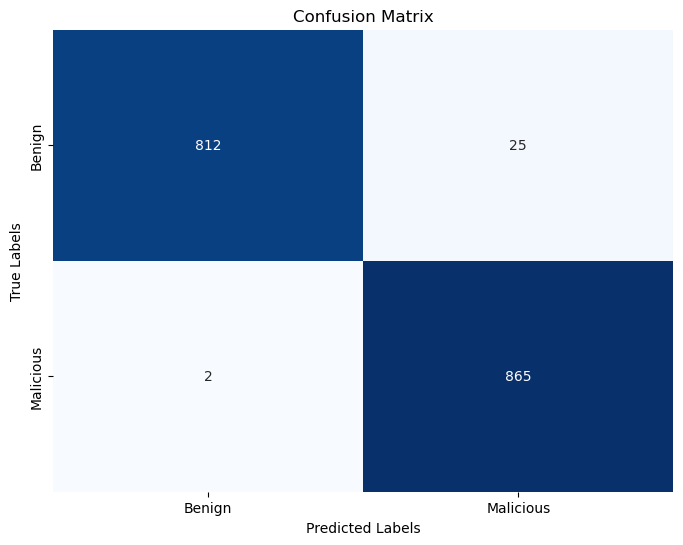

In [14]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=120, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9876760563380281
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99       837
           1       0.98      1.00      0.99       867

    accuracy                           0.99      1704
   macro avg       0.99      0.99      0.99      1704
weighted avg       0.99      0.99      0.99      1704



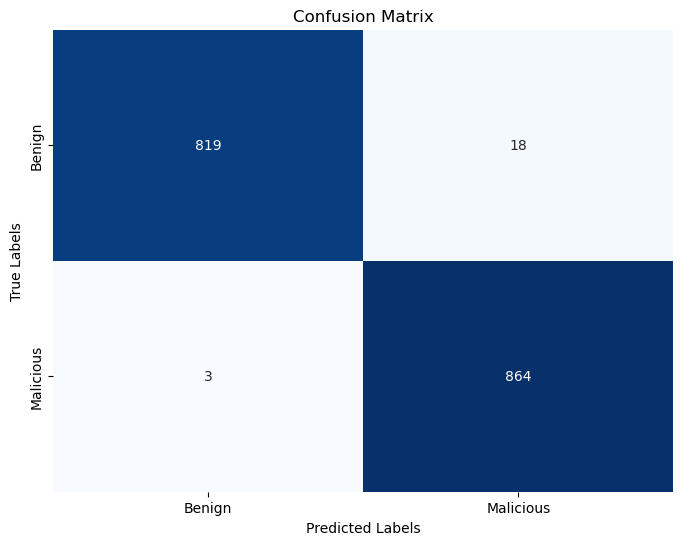

In [16]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [17]:
import xgboost as xgb

# Initialize and train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9847417840375586
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       837
           1       0.98      0.99      0.99       867

    accuracy                           0.98      1704
   macro avg       0.98      0.98      0.98      1704
weighted avg       0.98      0.98      0.98      1704



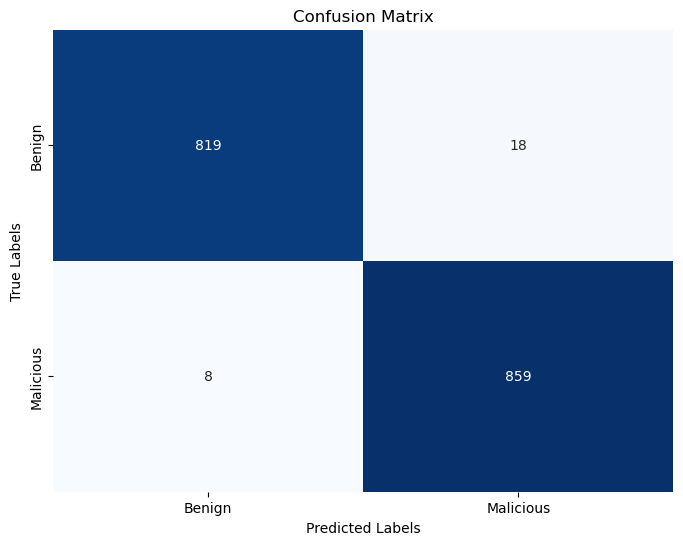

In [18]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Features Extraction

In [19]:
import math
from collections import Counter

# Function to calculate text length
def text_length(script):
    return len(script)

def entropy(script):
    # Count the occurrences of each character in the text
    character_counts = Counter(script)
    # Total number of characters in the text
    total_characters = len(script)
    # Calculate the probability of each character
    probabilities = [count / total_characters for count in character_counts.values()]
    # Calculate the entropy using the formula: H(X) = -Σ(p(x) * log2(p(x)))
    entropy_value = -sum(probability * math.log2(probability) for probability in probabilities)
    return entropy_value


# Function to count punctuation
def punctuation_count(script):
    return len(re.findall(r'[^\w\s]', script))

# Function to count function/procedure occurrences
def function_count(script):
    function_keywords = ['function', 'procedure']
    return sum(script.count(keyword) for keyword in function_keywords)

# Function to count numeric literals
def numeric_literal_count(script):
    return len(re.findall(r'\b\d+\b', script))

# Function to count string literals
def string_literal_count(script):
    return len(re.findall(r'"([^"]*)"', script))

# Function to check for the presence of error handling
def has_error_handling(script):
    error_handling_keywords = ['try', 'except', 'catch']
    return any(keyword in script for keyword in error_handling_keywords)

# Function to check for the presence of URLs or IPs
def has_urls_or_ips(script):
    return bool(re.search(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+|\d+\.\d+\.\d+\.\d+', script))

def has_obfuscation_indicators(script):
    # Define a list of obfuscation patterns
    obfuscation_patterns = [
        # Match string concatenation using '+'
        r'\b(?:\w+\s*\+\s*\w+)',
        # Match string encoding with ROT13
        r'\b(?:[a-zA-Z]\s*=\s*[^;]*\bchr\s*\(\s*\w+\s*\+\s*\d+\s*\)\s*;\s*)+',
        # Match hexadecimal encoding
        r'0x[\da-fA-F]+',
        # Match special character encoding
        r'(?:\\x[0-9a-fA-F]{2}|\\u[0-9a-fA-F]{4}|\\U[0-9a-fA-F]{8})',
        # Match specific PowerShell commands
        r'\b(?:Add-Type|dllimport|virtualalloc|createthread|memset)\b',
        # Match common obfuscation keywords
        r'\b(?:eval|exec|decode|encode|obfuscate)\b'
    ]
    # Check if any of the patterns match the script
    return any(re.search(pattern, script) for pattern in obfuscation_patterns)


# Function to check for the presence of information disclosure keywords
def has_suspicious_words(script):
    disclosure_keywords = ['downloadfile','password', 'secret', 'key', 'token', 'downloadstring',
                          'dllimport', 'programdata', 'new object', 'appdata']
    return any(keyword in script for keyword in disclosure_keywords)


def longest_string_length(script):
    # Extract all string literals
    string_literals = re.findall(r'"([^"]*)"', script)
    # If there are no string literals, return 0
    if not string_literals:
        return 0
    # Find the length of the longest string
    longest_length = max(len(string_literal) for string_literal in string_literals)
    return longest_length

In [20]:
# mal_df

In [21]:
features = ['text_length', 'function_count',  
           'numeric_literal_count', 'has_error_handling',
           'has_obfuscation_indicators','has_suspicious_words']
functions = [text_length, function_count,
             numeric_literal_count, has_error_handling,
             has_obfuscation_indicators,has_suspicious_words]

features_ = ['Entropy', 'punctuation_count', 'longest_string_length','string_literal_count', 'has_urls_or_ips']
functions_ = [entropy, punctuation_count, longest_string_length, string_literal_count, has_urls_or_ips]

for i in range(len(functions)):
    mal_df[features[i]] = mal_df['cleaned_script'].apply(functions[i]).astype(int)
    
for i in range(len(functions_)):
    mal_df[features_[i]] = mal_df['script'].apply(functions_[i]).astype(int)

In [22]:
# mal_df

## Data Exploration

In [23]:
mal_df['has_suspicious_words'].value_counts()

has_suspicious_words
1    6204
0    2314
Name: count, dtype: int64

In [24]:
# mal
mal = mal_df[(mal_df['has_suspicious_words'] == 0) & (mal_df['label'] == 0)]
mal['cleaned_script']

483      invoke webrequest  uri http   stderr pl procd...
524      mkdir  force  env temp tcd506a_ tmp invoke we...
534      if     nslookup  q txt p s pn ns sse net pl  ...
723      if     nslookup  q txt p s os ns rankingplac ...
742      if     nslookup  q txt p s os ns rankingplac ...
1050     if     nslookup  q txt l ns topbrains pl    m...
1226      text    hello world bbb   text   out file   ...
1600     if     nslookup  q txt l ns topbrains pl    m...
1702      uninstall32s   gci  hklm  software wow6432no...
1752     if     nslookup  q txt l ns topbrains pl    m...
1756     if     nslookup  q txt p s rk ns rankingplac ...
2276     function userguide    eqldocpath    get itemp...
2298     if     nslookup  q txt p s w2 ns rankingplac ...
2320      b get content  env windir system32 1 txt set...
2355     function userguide    eqldocpath    get itemp...
2927      uninstall32s   gci  hklm  software wow6432no...
2982     if     nslookup  q txt l ns huawel ro    matc...
3023    functi

In [25]:
benign = mal_df[(mal_df['has_suspicious_words'] == 1) & (mal_df['label'] == 1)]
benign['cleaned_script']

4206      function test createsnewsimpleresource    rg...
4209     import module  name  join path  path  psscrip...
4210     function invoke psexec    cmdletbinding    pa...
4211     function test cdotnet    cmdletbinding    par...
4212     function get snmpdata   param    string  ip  ...
                              ...                        
8508        join path  path  psscriptroot  childpath  ...
8510     function out rsfoldercontent    cmdletbinding...
8512      function new codesigningcertificate    cmdle...
8513     function set rsemailsettings    cmdletbinding...
8515     function get authtoken    cmdletbinding    pa...
Name: cleaned_script, Length: 2022, dtype: object

In [26]:
mal_df['has_obfuscation_indicators'].value_counts()

has_obfuscation_indicators
0    6243
1    2275
Name: count, dtype: int64

In [27]:
mal_df.columns

Index(['script', 'label', 'cleaned_script', 'text_length', 'function_count',
       'numeric_literal_count', 'has_error_handling',
       'has_obfuscation_indicators', 'has_suspicious_words', 'Entropy',
       'punctuation_count', 'longest_string_length', 'string_literal_count',
       'has_urls_or_ips'],
      dtype='object')

<Axes: >

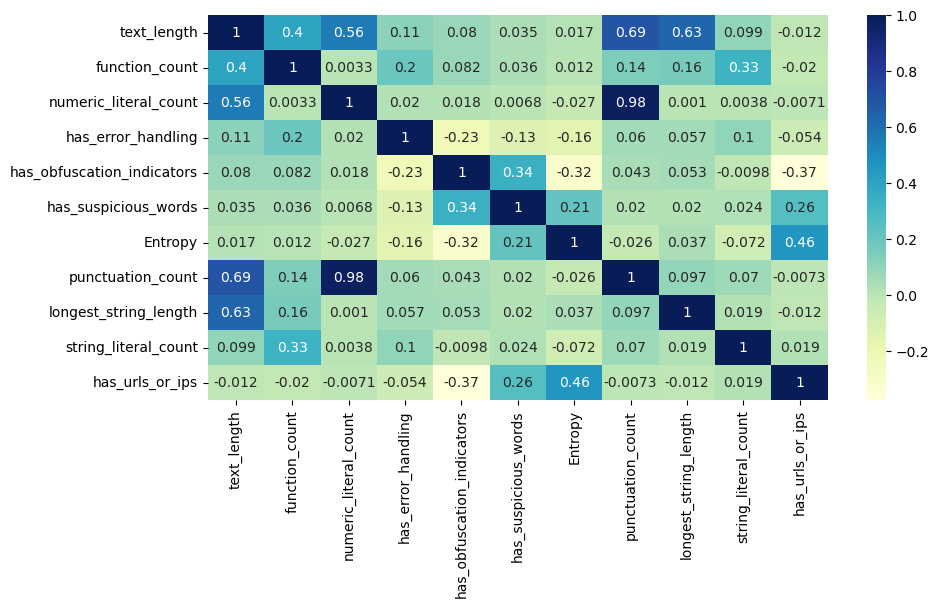

In [28]:
col = mal_df.columns[3:]
corr_df = mal_df[col]
#correlation
plt.figure(figsize=(10,5))
sns.heatmap(corr_df.corr(),annot=True,cmap="YlGnBu")

In [29]:
corr_df.columns

Index(['text_length', 'function_count', 'numeric_literal_count',
       'has_error_handling', 'has_obfuscation_indicators',
       'has_suspicious_words', 'Entropy', 'punctuation_count',
       'longest_string_length', 'string_literal_count', 'has_urls_or_ips'],
      dtype='object')

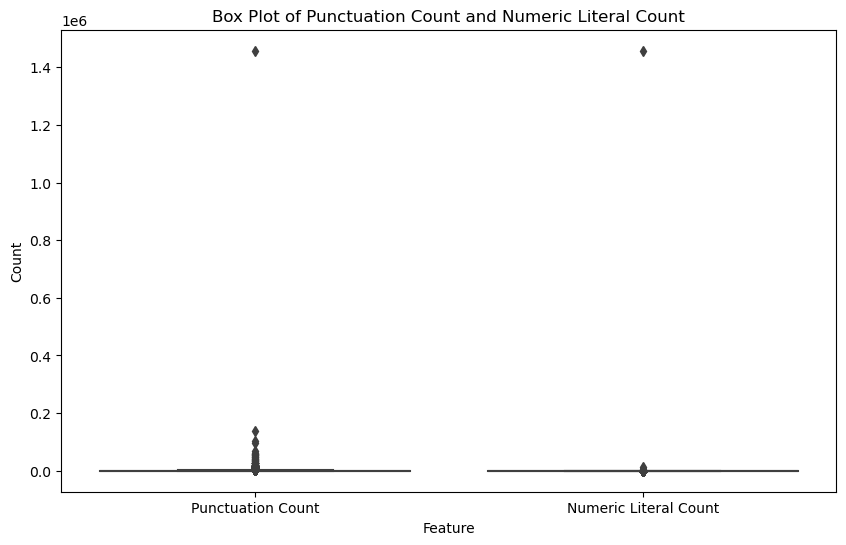

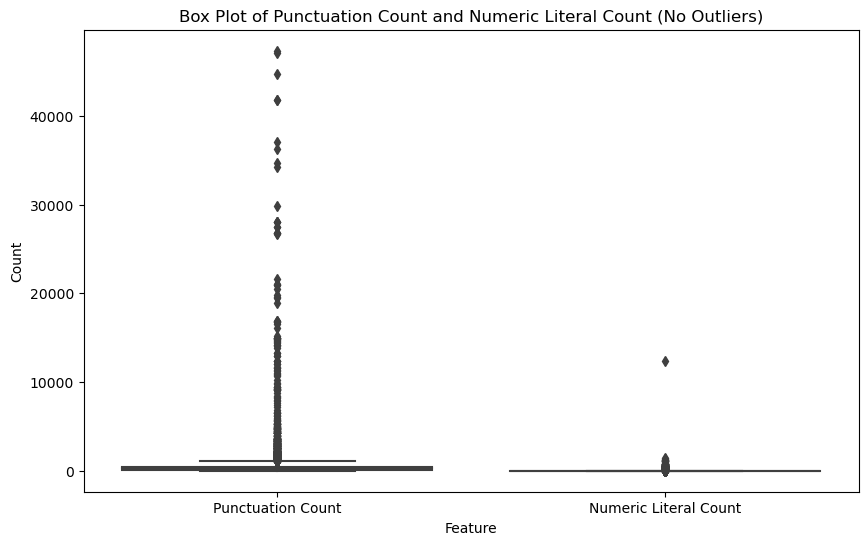

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=mal_df[['punctuation_count', 'numeric_literal_count']])
plt.title('Box Plot of Punctuation Count and Numeric Literal Count')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks([0, 1], ['Punctuation Count', 'Numeric Literal Count'])
plt.show()

# Z-score method
from scipy import stats

z_scores = stats.zscore(mal_df[['punctuation_count', 'numeric_literal_count']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)  # Keep only data points with Z-score < 3
mal_df = mal_df[filtered_entries]

# Visualize the data without outliers using box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=mal_df[['punctuation_count', 'numeric_literal_count']])
plt.title('Box Plot of Punctuation Count and Numeric Literal Count (No Outliers)')
plt.xlabel('Feature')
plt.ylabel('Count')
plt.xticks([0, 1], ['Punctuation Count', 'Numeric Literal Count'])
plt.show()

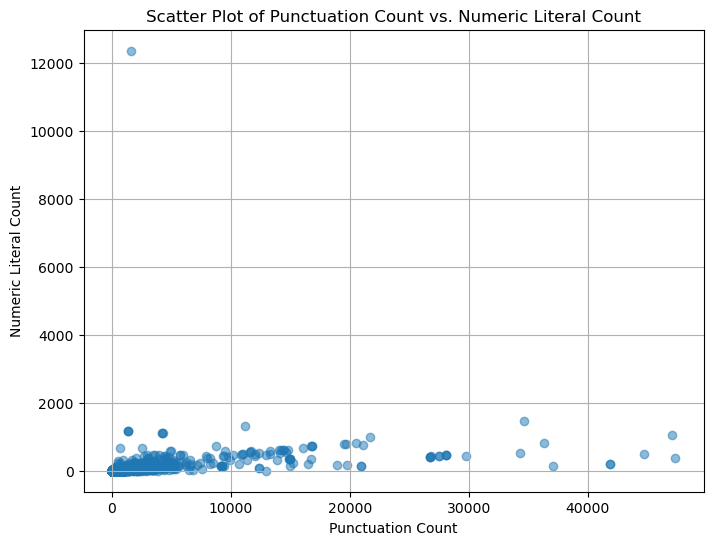

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(mal_df['punctuation_count'], mal_df['numeric_literal_count'], alpha=0.5)
plt.title('Scatter Plot of Punctuation Count vs. Numeric Literal Count')
plt.xlabel('Punctuation Count')
plt.ylabel('Numeric Literal Count')
plt.grid(True)
plt.show()

In [32]:
mal_df['has_urls_or_ips'].value_counts()

has_urls_or_ips
0    5865
1    2642
Name: count, dtype: int64

In [33]:
mal_df[mal_df['has_obfuscation_indicators'] == 0]['script']

1       \n(New-Object System.Net.WebClient).DownloadFi...
2       \n$x=$Env:username;$u="http://54.213.195.138/s...
3       \n(New-Object System.Net.WebClient).DownloadFi...
4       \n(New-Object System.Net.WebClient).DownloadFi...
6       \n(New-Object System.Net.WebClient).DownloadFi...
                              ...                        
8513    \n\n\nfunction Set-RsEmailSettings\n{\n    \n ...
8514    \n\n\n\n\n\n\n\n\n\n\n\n\n\n\nfunction Test-E2...
8515    \n\n\n\nfunction Get-AuthToken {\n\n\n\n[cmdle...
8516    ﻿function Get-MSHotFixes\n{\n\n\n$hotfixes = G...
8517    ﻿\n\n$(foreach($file in (ls *Prox.xml)) {\n   ...
Name: script, Length: 6242, dtype: object

In [34]:
mal_df['has_error_handling'].value_counts()

has_error_handling
0    6409
1    2098
Name: count, dtype: int64

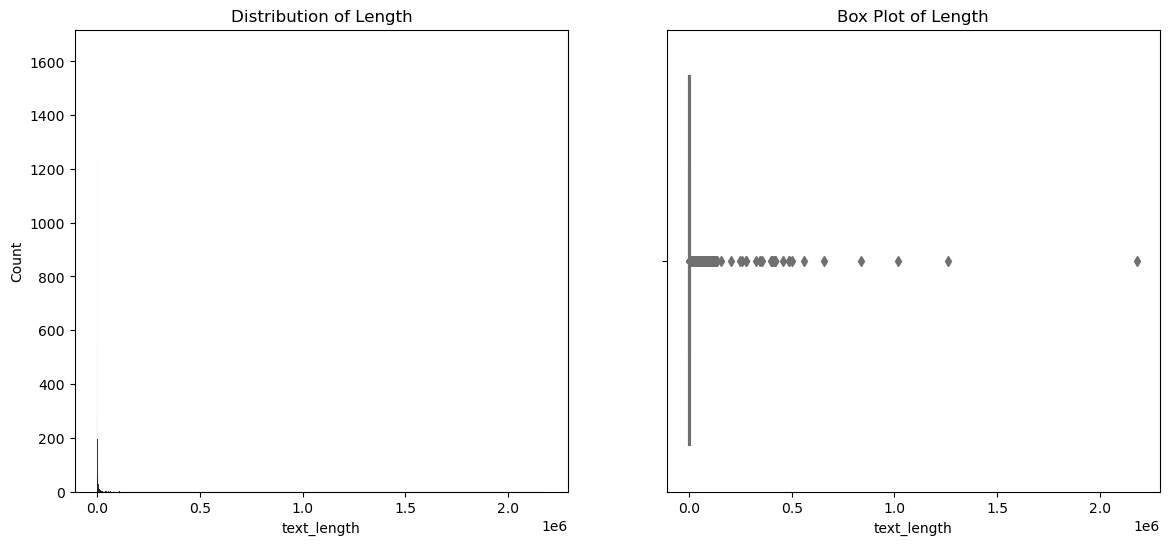

In [35]:
# Set up the figure and axes
f, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram
sns.histplot(mal_df['text_length'], color="black", ax=axes[0])
axes[0].set_title("Distribution of Length")

# Plot the box plot to identify outliers
sns.boxplot(x=mal_df['text_length'], ax=axes[1], color="skyblue")
axes[1].set_title("Box Plot of Length")

plt.show()

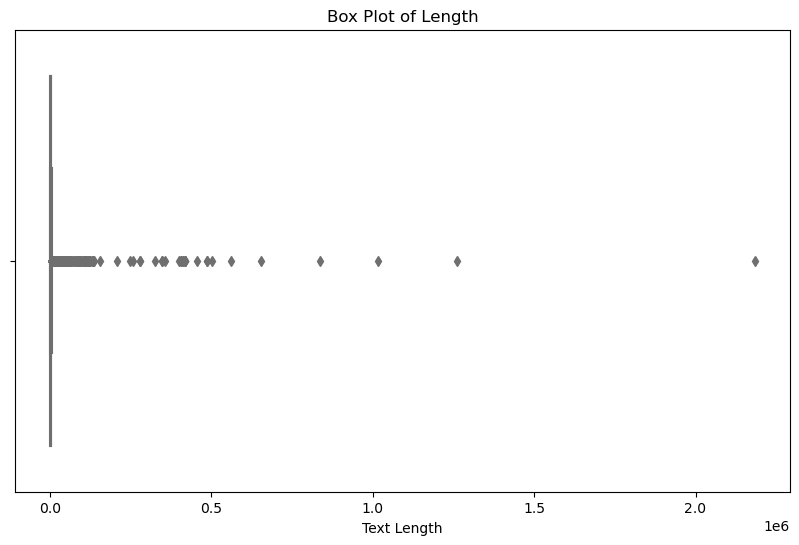

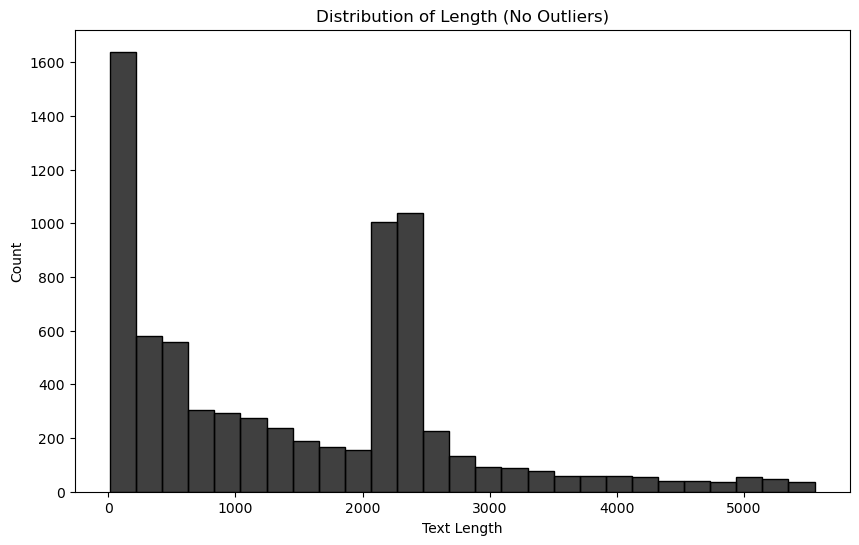

In [36]:
# Visualize the distribution of text_length
plt.figure(figsize=(10, 6))
sns.boxplot(x=mal_df['text_length'], color="skyblue")
plt.title("Box Plot of Length")
plt.xlabel("Text Length")
plt.show()

# Calculate the interquartile range (IQR)
Q1 = mal_df['text_length'].quantile(0.25)
Q3 = mal_df['text_length'].quantile(0.75)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mal_df = mal_df[(mal_df['text_length'] >= lower_bound) & (mal_df['text_length'] <= upper_bound)]

# Visualize the distribution without outliers
plt.figure(figsize=(10, 6))
sns.histplot(mal_df['text_length'], color="black")
plt.title("Distribution of Length (No Outliers)")
plt.xlabel("Text Length")
plt.show()

<Axes: >

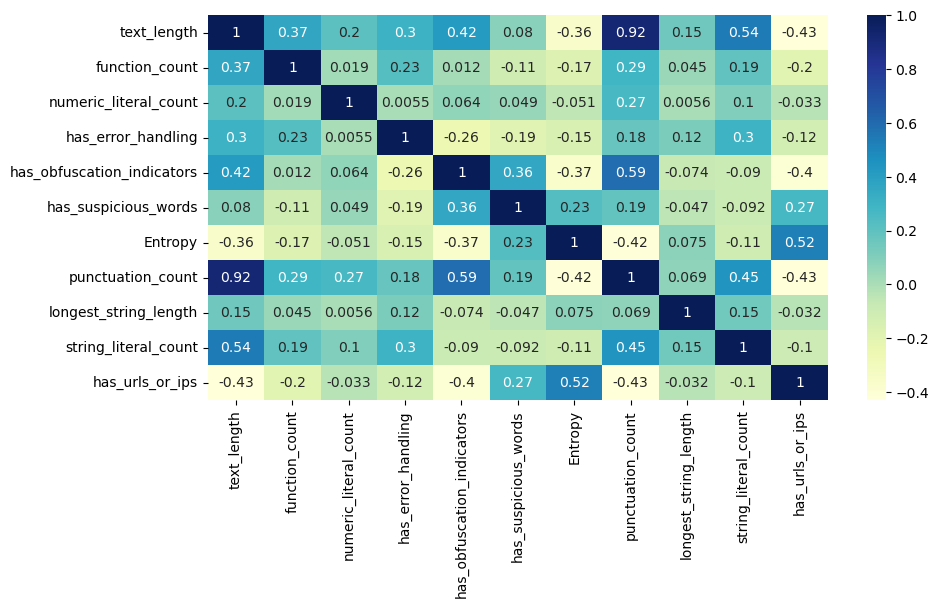

In [37]:
col = mal_df.columns[3:]
corr_df = mal_df[col]
#correlation
plt.figure(figsize=(10,5))
sns.heatmap(corr_df.corr(),annot=True,cmap="YlGnBu")

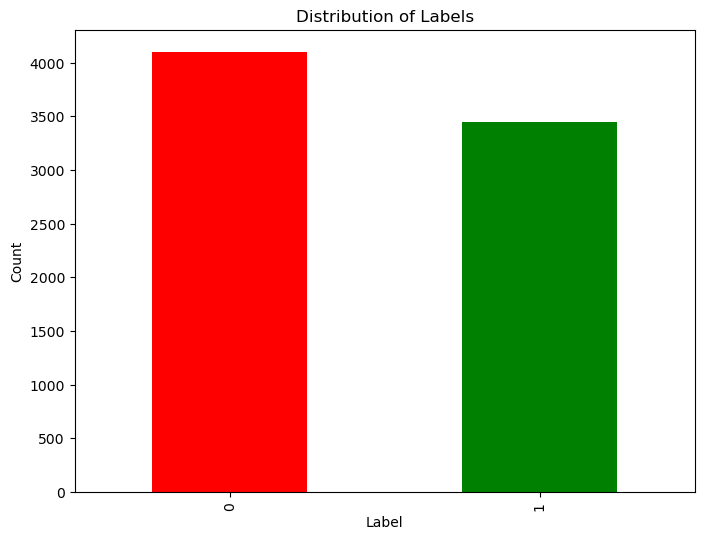

In [38]:
# malicious = 0, benign = 1
label_counts = mal_df['label'].value_counts()

# Plotting the bar chart
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['red', 'green'])
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [39]:
both = mal_df[(mal_df['has_obfuscation_indicators'] == 1) & (mal_df['has_suspicious_words'] == 1)]
both['script']

0       \n$c = '[DllImport("kernel32.dll")]public stat...
5       \n$Vtao = '[DllImport("kernel32.dll")]public s...
8       \n$q0I = '[DllImport("kernel32.dll")]public st...
9       \n$Fdm = '[DllImport("kernel32.dll")]public st...
15      \n$6pVS = '[DllImport("kernel32.dll")]public s...
                              ...                        
8273    \n\nDescribe "Group-Object DRT Unit Tests" -Ta...
8370    \n\n\nDescribe "Validate start of console host...
8384    \n\n\n\n\n\nusing namespace System.Threading\n...
8413    \n\n\nif (($PSVersionTable.PSVersion.Major -ge...
8483    \n$Database = "dbamaint"\n$Server = "PSQLPA24"...
Name: script, Length: 2062, dtype: object

<Axes: xlabel='label', ylabel='count'>

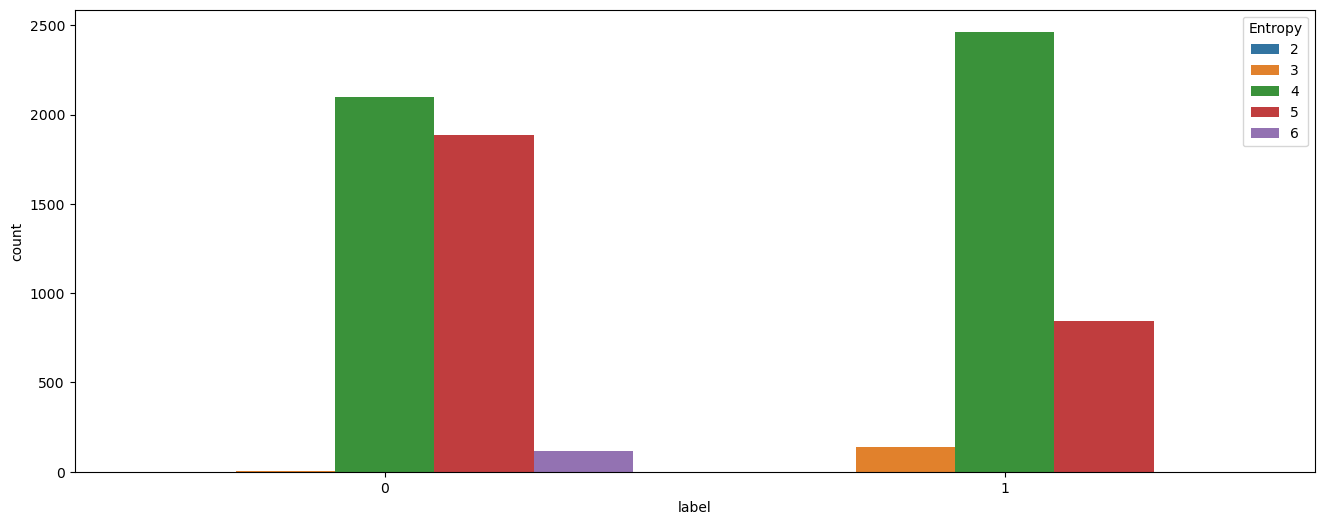

In [40]:
plt.figure(figsize=(16, 6))
sns.countplot(x='label', hue='Entropy', data=mal_df)

<Axes: xlabel='Entropy', ylabel='count'>

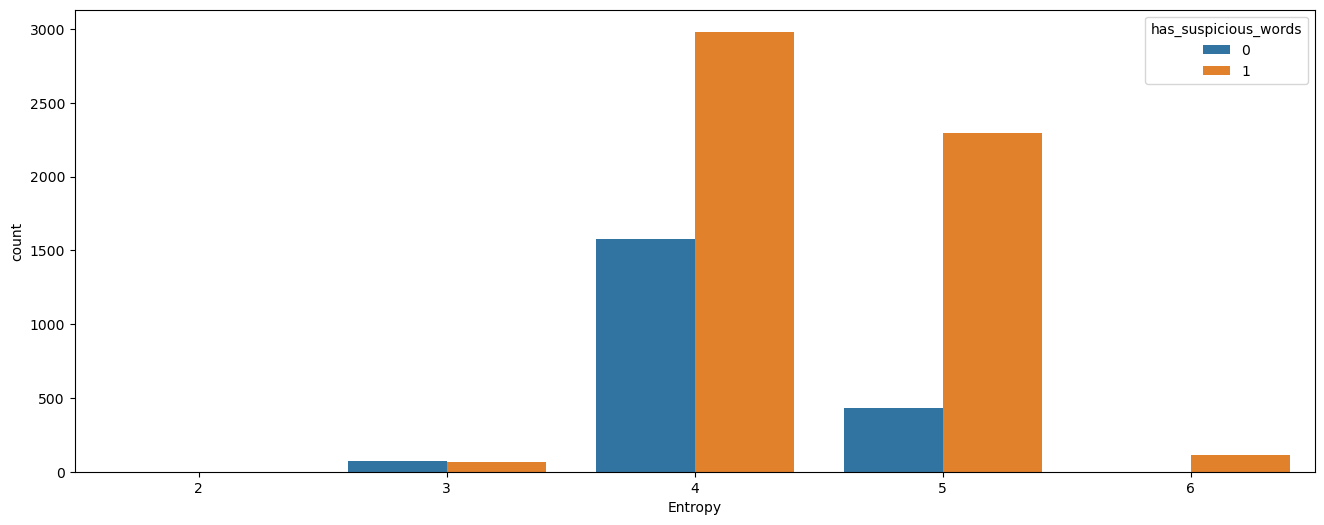

In [41]:
plt.figure(figsize=(16, 6))
sns.countplot(x='Entropy', hue='has_suspicious_words', data=mal_df)

<Axes: xlabel='has_obfuscation_indicators', ylabel='count'>

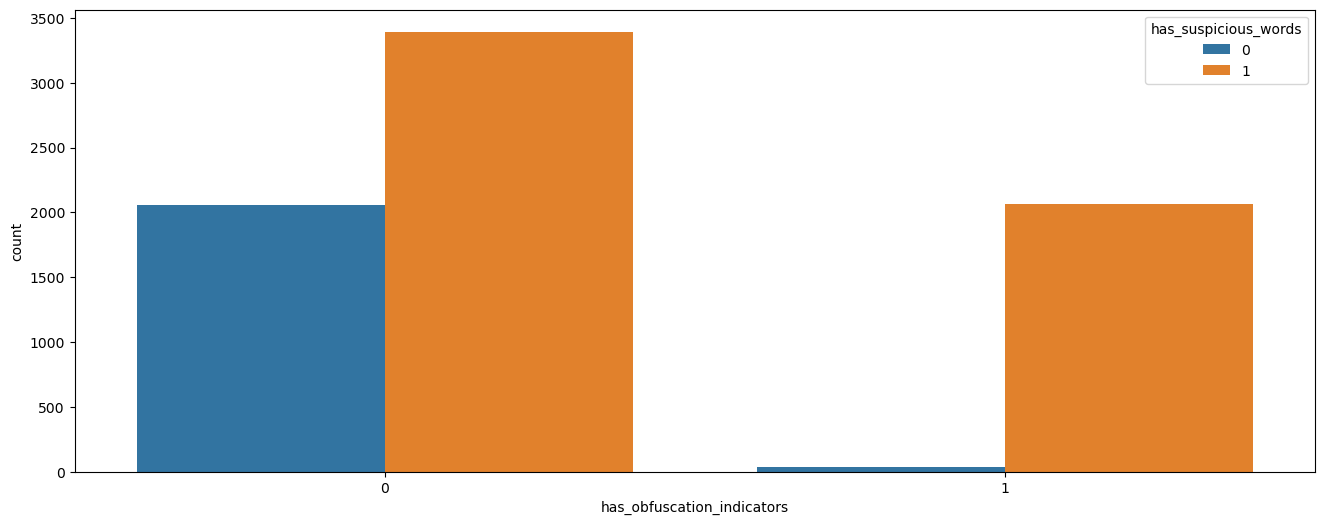

In [42]:
plt.figure(figsize=(16, 6))
sns.countplot(x='has_obfuscation_indicators', hue='has_suspicious_words', data=mal_df)

<Axes: xlabel='label', ylabel='count'>

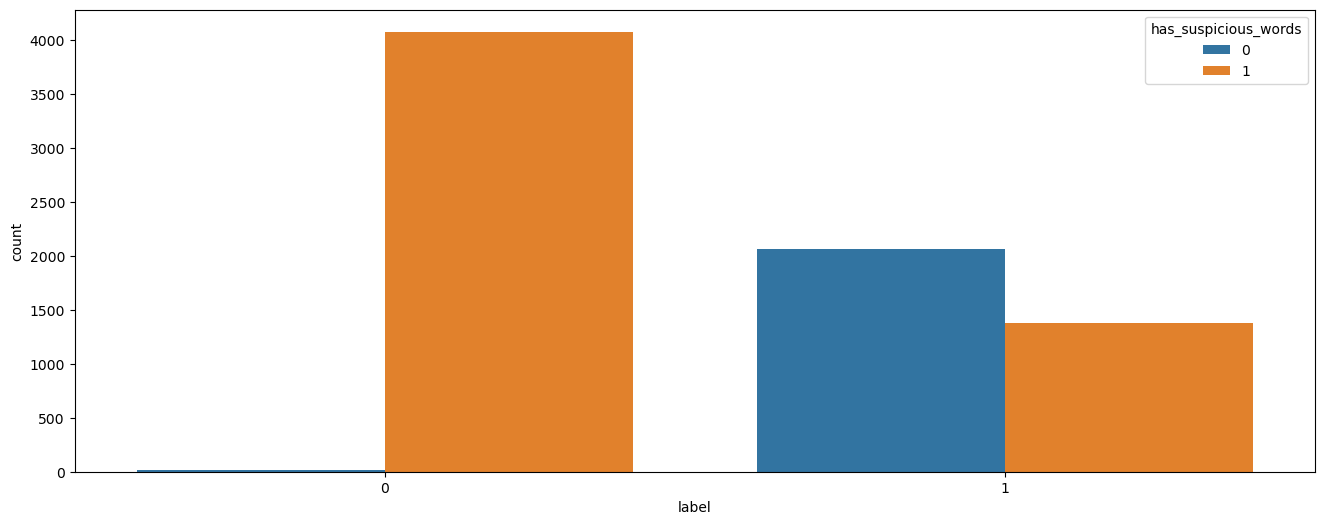

In [43]:
plt.figure(figsize=(16, 6))
sns.countplot(x='label', hue='has_suspicious_words', data=mal_df)

<Axes: xlabel='label', ylabel='count'>

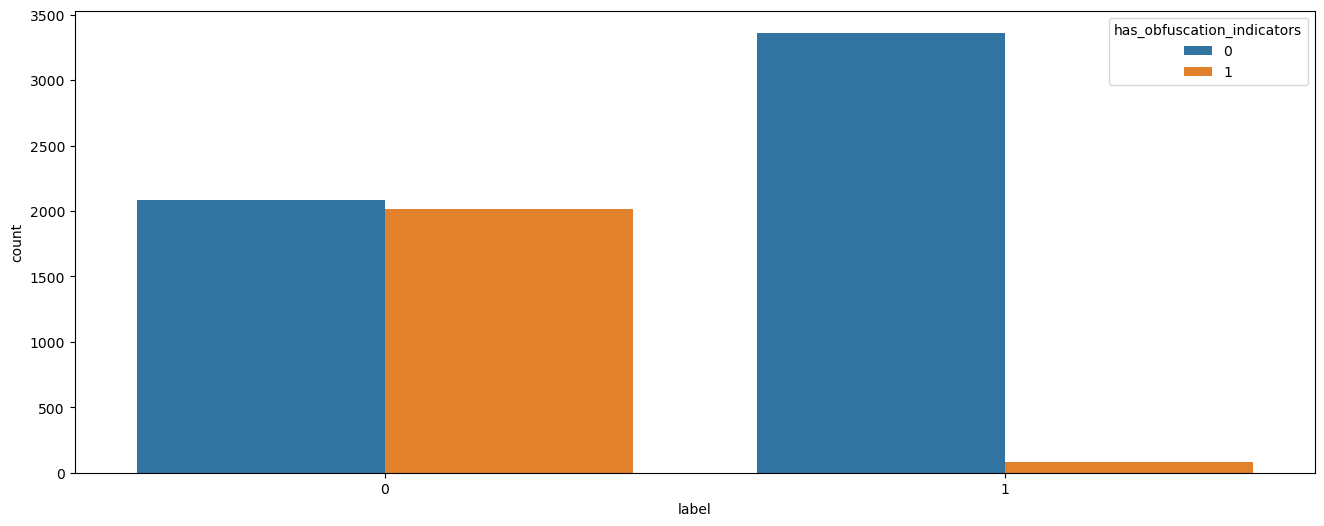

In [44]:
plt.figure(figsize=(16, 6))
sns.countplot(x='label', hue='has_obfuscation_indicators', data=mal_df)

<Axes: xlabel='label', ylabel='count'>

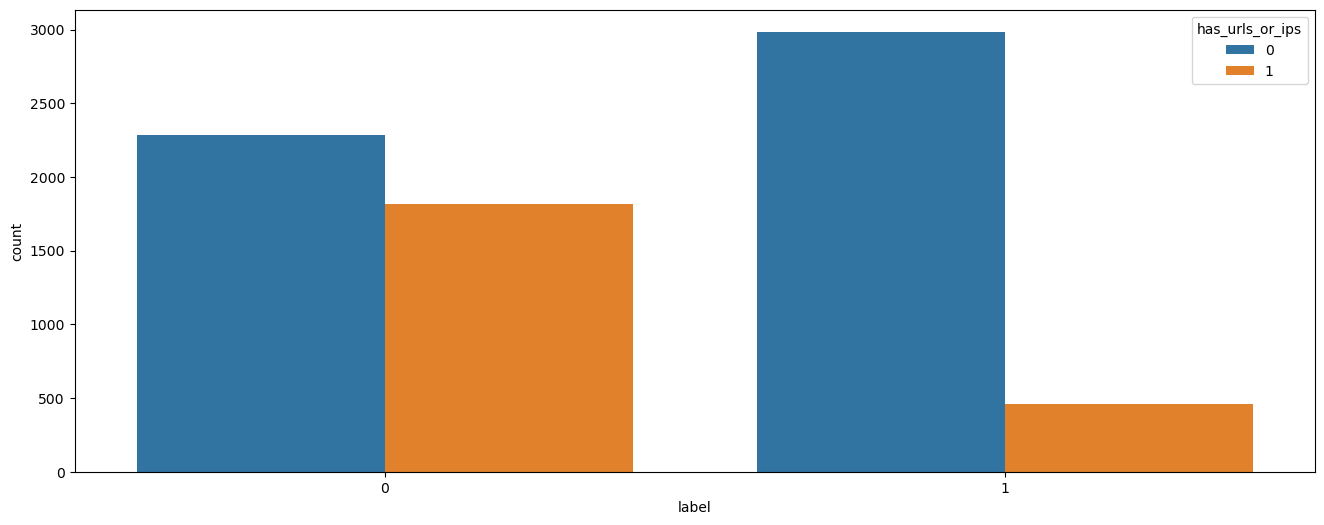

In [45]:
plt.figure(figsize=(16, 6))
sns.countplot(x='label', hue='has_urls_or_ips', data=mal_df)

## Features Selection

In [46]:
mal_df.columns

Index(['script', 'label', 'cleaned_script', 'text_length', 'function_count',
       'numeric_literal_count', 'has_error_handling',
       'has_obfuscation_indicators', 'has_suspicious_words', 'Entropy',
       'punctuation_count', 'longest_string_length', 'string_literal_count',
       'has_urls_or_ips'],
      dtype='object')

In [47]:
# Extract features and labels
X = mal_df['cleaned_script']
y = mal_df['label']

# Create TF-IDF vectorizer
ngram_range = (1, 3)  
max_features = 10000 

# Create TF-IDF vectorizer with specified parameters
vectorizer = TfidfVectorizer(ngram_range=ngram_range, max_features=max_features)
# Fit and transform the data
X_tfidf = vectorizer.fit_transform(X)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

In [48]:
import pickle
# Save the TF-IDF vectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

In [49]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

# Define the number of features to select
k = 1000 

# Create SelectKBest instance with chi-square scoring function
selector = SelectKBest(score_func=chi2, k=k)

# Fit selector to the data and transform the data
X_selected = selector.fit_transform(X_tfidf, y)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features
selected_feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

# Convert the selected features to a DataFrame
X_selected_df = pd.DataFrame(X_selected.toarray(), columns=selected_feature_names)

In [50]:
import pickle

# Save the SelectKBest instance
with open('selector.pkl', 'wb') as file:
    pickle.dump(selector, file)

# Save the selected feature names DataFrame
X_selected_df.to_pickle('selected_features.pkl')

In [51]:
# X_selected_df

In [52]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected_df, y, test_size=0.2, random_state=42)

In [53]:
# Initialize and train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9907223326706428
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       839
           1       0.99      0.99      0.99       670

    accuracy                           0.99      1509
   macro avg       0.99      0.99      0.99      1509
weighted avg       0.99      0.99      0.99      1509



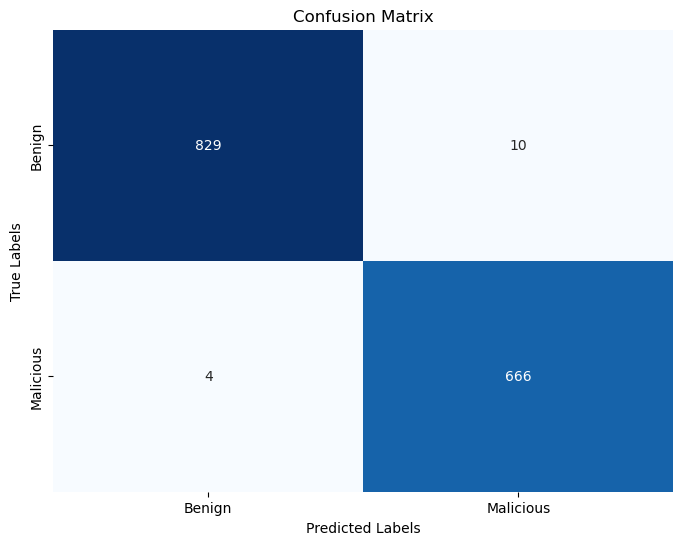

In [54]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [55]:
# Initialize and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9913850231941683
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       839
           1       0.98      1.00      0.99       670

    accuracy                           0.99      1509
   macro avg       0.99      0.99      0.99      1509
weighted avg       0.99      0.99      0.99      1509



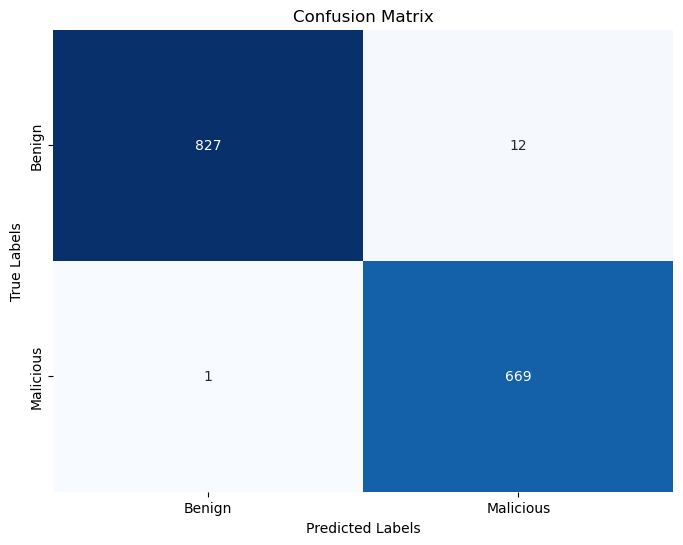

In [56]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## Combine handcrafted features to TF-IDF selected features

In [57]:
# comb_df = pd.concat([corr_df.reset_index(drop=True), X_selected_df.reset_index(drop=True)], axis=1, join='inner')
comb_df = pd.concat([X_selected_df.reset_index(drop=True), corr_df.reset_index(drop=True)], axis=1, join='inner')

In [58]:
comb_df

,0x00,0x00 0x00,0x00 0x00 0x00,0x00 0x00 0x60,0x00 0x00 0x68,0x00 0x10,0x00 0x10 0x00,0x00 0x56,0x00 0x60,0x00 0x60 0x89,...,function_count,numeric_literal_count,has_error_handling,has_obfuscation_indicators,has_suspicious_words,Entropy,punctuation_count,longest_string_length,string_literal_count,has_urls_or_ips
0,0.263051,0.099954,0.020042,0.020048,0.020048,0.020042,0.020048,0.04054,0.020031,0.020048,...,1,10,0,1,1,4,444,12,4,0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0,4,0,0,1,5,37,23,2,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0,4,0,0,1,5,70,31,1,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0,4,0,0,1,5,37,22,2,1
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0,0,0,0,1,5,35,19,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7540,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0,1,1,0,0,4,180,47,3,0
7541,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,2,1,0,1,4,290,88,16,0
7542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,10,0,0,0,3,173,12,10,0
7543,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1,0,0,0,0,5,57,11,3,0


In [59]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(comb_df, y, test_size=0.2, random_state=42)

In [60]:
# Initialize and train an XGBoost model
xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9933730947647449
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       839
           1       0.99      1.00      0.99       670

    accuracy                           0.99      1509
   macro avg       0.99      0.99      0.99      1509
weighted avg       0.99      0.99      0.99      1509



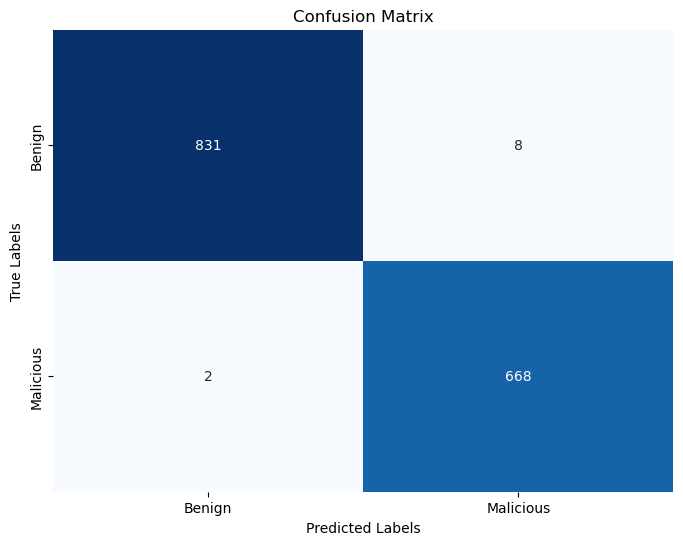

In [61]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

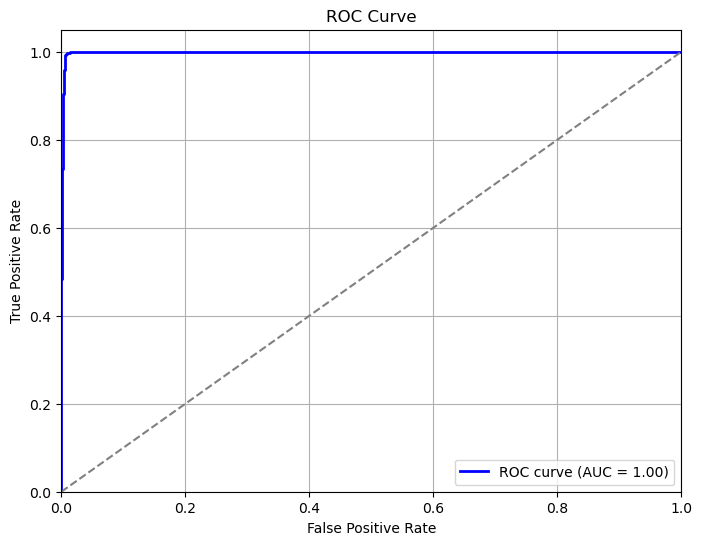

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for the positive class
y_probs = xgb_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [62]:
# Initialize and train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9907223326706428
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99       839
           1       0.98      1.00      0.99       670

    accuracy                           0.99      1509
   macro avg       0.99      0.99      0.99      1509
weighted avg       0.99      0.99      0.99      1509



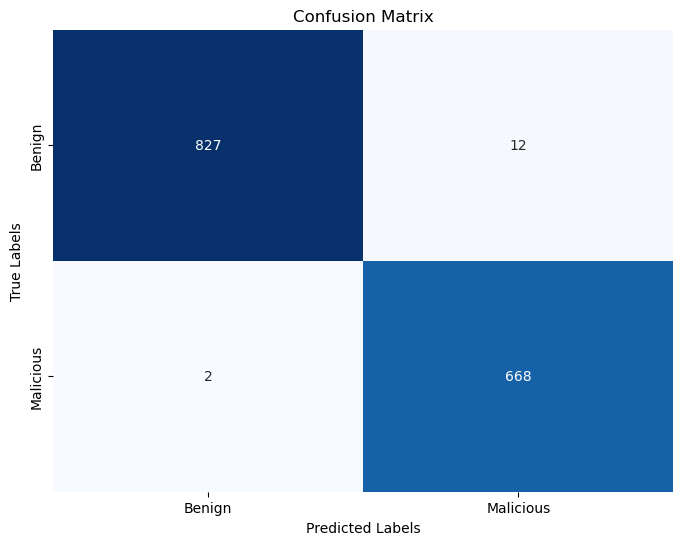

In [63]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, 
            xticklabels=['Benign', 'Malicious'], yticklabels=['Benign', 'Malicious'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

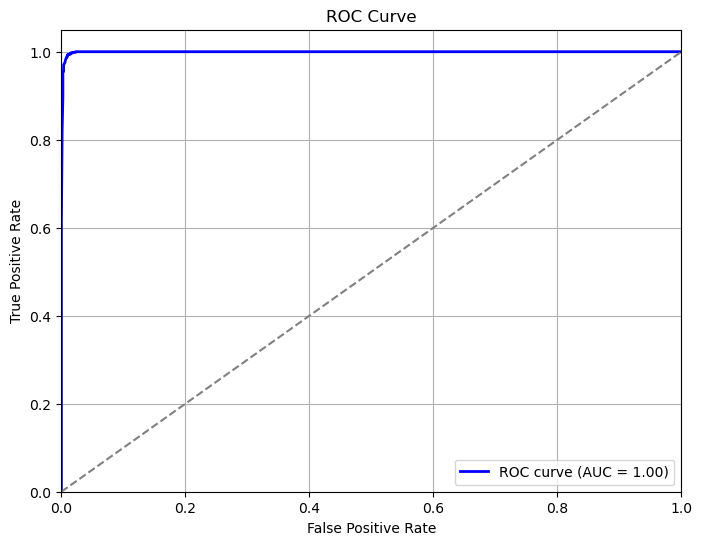

In [75]:
# Get predicted probabilities for the positive class
y_probs = rf_model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [64]:
X_train.columns

Index(['0x00', '0x00 0x00', '0x00 0x00 0x00', '0x00 0x00 0x60',
       '0x00 0x00 0x68', '0x00 0x10', '0x00 0x10 0x00', '0x00 0x56',
       '0x00 0x60', '0x00 0x60 0x89',
       ...
       'function_count', 'numeric_literal_count', 'has_error_handling',
       'has_obfuscation_indicators', 'has_suspicious_words', 'Entropy',
       'punctuation_count', 'longest_string_length', 'string_literal_count',
       'has_urls_or_ips'],
      dtype='object', length=1011)

In [65]:
import pickle

# save the iris classification model as a pickle file
model_pkl_file = "model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(xgb_model, file)

## fivefold cross-validation

In [78]:
import numpy as np
from sklearn.model_selection import KFold, cross_val_score

# Concatenate train and test data
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True)

# Initialize a list to store evaluation metrics for each fold
metrics = []

# Initialize XGBoost classifier
cross_xgb_model = xgb.XGBClassifier()

# Iterate over the splits
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Train and evaluate the model using cross_val_score
    accuracy = cross_val_score(cross_xgb_model, X_train_fold, y_train_fold, cv=5, scoring='accuracy')
    
    # Store the average accuracy across folds
    metrics.append(np.mean(accuracy))

# Average the metrics over the folds
average_accuracy = np.mean(metrics)


In [79]:
average_accuracy

0.9917498916365352

In [80]:
metrics

[0.9922138793023038,
 0.9918824791366039,
 0.9920479048815685,
 0.9915512161398464,
 0.9910539787223536]

In [70]:
# Concatenate train and test data
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True)

# Initialize a list to store evaluation metrics for each fold
metrics = []

# Initialize XGBoost classifier
cross_rf_model = RandomForestClassifier(n_estimators=50, random_state=42)

# Iterate over the splits
for train_index, test_index in kf.split(X):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Train and evaluate the model using cross_val_score
    accuracy = cross_val_score(cross_rf_model, X_train_fold, y_train_fold, cv=5, scoring='accuracy')
    
    # Store the average accuracy across folds
    metrics.append(np.mean(accuracy))

# Average the metrics over the folds
average_accuracy = np.mean(metrics)

In [71]:
average_accuracy

0.9912197336727807

In [72]:
metrics

[0.9910538415534109,
 0.9912202274809747,
 0.9905570156427462,
 0.9918820676297756,
 0.9913855160569964]